# Segmentação de Clientes

> <p align='justify'> Neste trabalho, usaremos o banco de dados da Olist com K-means para identificar a frequência, recência e receita dos consumidores e agrupá-los em categorias de compras. Assim podemos fazer campanhas de marketing específicas, além de criar programas de recompensas para os clientes que mais consomem.</p>

### Bibliotecas básicas e outras inicializações

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline
warnings.filterwarnings('ignore')

### Carregando a base de dados

In [2]:
df = pd.read_csv('./datasets/dados.csv')
print(f'Linhas: {df.shape[0]} | Colunas: {df.shape[1]}')

Linhas: 116581 | Colunas: 27


In [3]:
df.head()

,amostra,id_cliente,id_unico_cliente,item_id,cep_cliente,cidade_cliente,estado_cliente,id_pedido,status_pedido,horario_pedido,...,pagamento_sequencial,pagamento_tipo,pagamento_prestacoes,pagamento_valor,review,categoria,categoria_ingles,cep_vendedor,cidade_vendedor,estado_vendedor
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,1,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,1,credit_card,2,146.87,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
1,1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,1,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
2,2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,2,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,...,1,credit_card,1,275.79,1,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
3,3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,1,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,...,1,credit_card,7,140.61,3,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP
4,4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,1,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,...,1,credit_card,10,137.58,4,moveis_escritorio,office_furniture,8577,itaquaquecetuba,SP


### Informação dos dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   amostra               116581 non-null  int64  
 1   id_cliente            116581 non-null  object 
 2   id_unico_cliente      116581 non-null  object 
 3   item_id               116581 non-null  int64  
 4   cep_cliente           116581 non-null  int64  
 5   cidade_cliente        116581 non-null  object 
 6   estado_cliente        116581 non-null  object 
 7   id_pedido             116581 non-null  object 
 8   status_pedido         116581 non-null  object 
 9   horario_pedido        116581 non-null  object 
 10  pedido_aprovado       116567 non-null  object 
 11  pedido_entregador     115368 non-null  object 
 12  pedido_entregue       114066 non-null  object 
 13  data_estimada         116581 non-null  object 
 14  id_vendedor           116581 non-null  object 
 15  

### Análise Exploratória

In [5]:
def plot_perc(st, text, dados):
    plt.figure(figsize=(20, 8))

    g = sns.countplot(x=st, data=dados, orient='h')
    g.set_title(f'Distribuição {text}', fontsize=16)
    g.set_ylabel('Contagem', fontsize=14)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/1.6, height + 200,
               '{:1.2f}%'.format(height/116581*100), ha='center', va='bottom', fontsize=12)
    g.set_ylim(0, max(sizes) * 1.1)

#### Clientes por estado

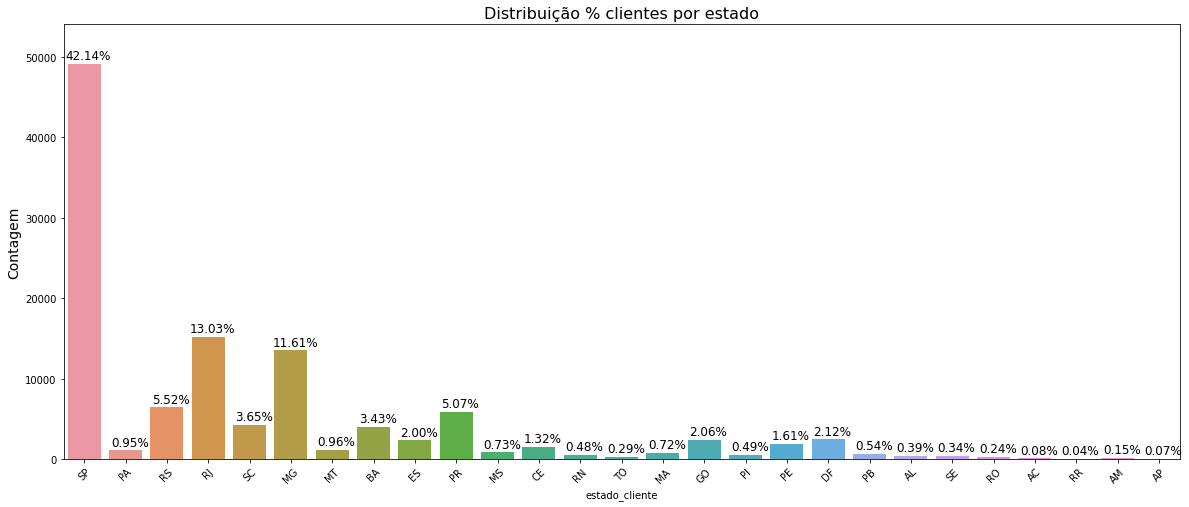

In [6]:
plot_perc('estado_cliente', '% clientes por estado', df)

#### Vendedores por estado

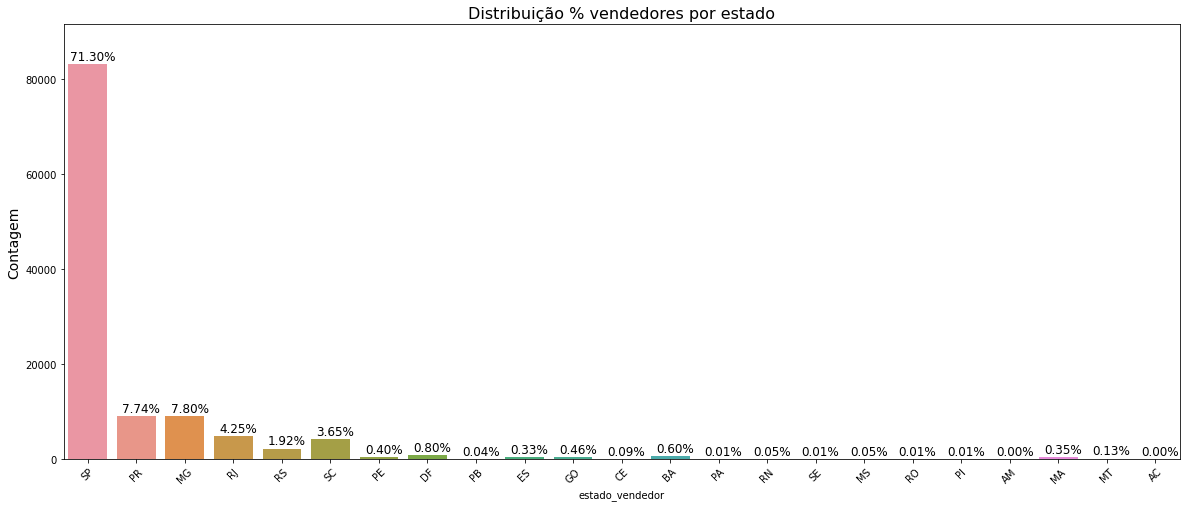

In [7]:
plot_perc('estado_vendedor', '% vendedores por estado', df)

#### Método de pagamento mais utilizado

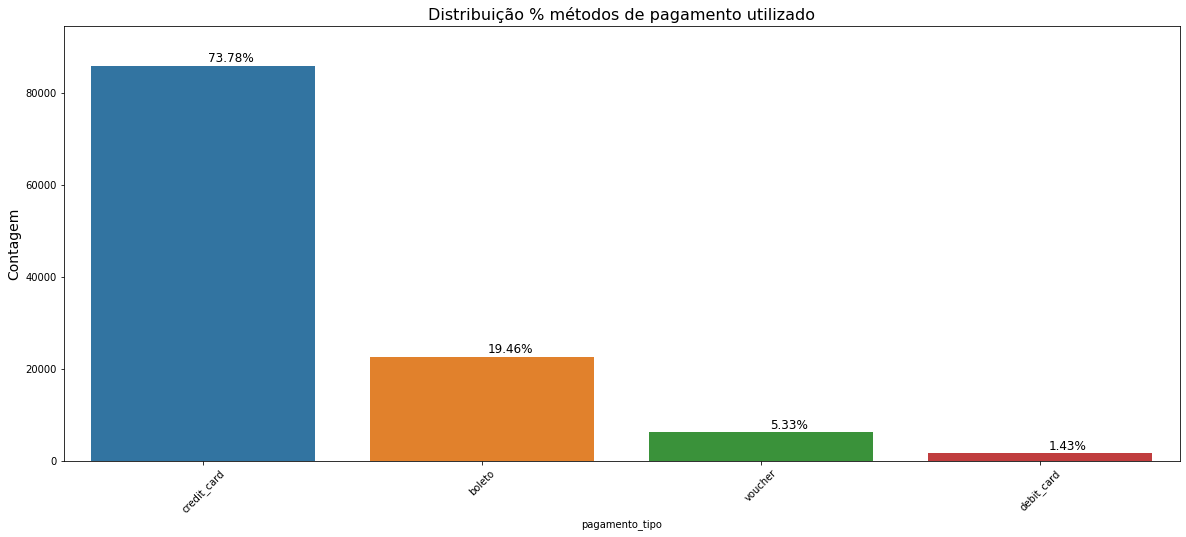

In [9]:
plot_perc('pagamento_tipo', '% métodos de pagamento utilizado', df)

### Modelo RFM para segmentação de clientes

> <p align='justify'><b>Recência (R):</b> há quantos dias foi a última compra desse cliente?</p>
> <p align='justify'><b>Frequência (F):</b> quantas compras esse cliente já fez na sua empresa desde que se cadastrou?</p>
> <p align='justify'><b>Monetariedade (M):</b> quanto esse cliente já gastou em dinheiro na sua empresa?</p>

In [16]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco']].copy()
df_olist.head(2)

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99


In [17]:
df_compra = df.groupby('id_unico_cliente')['horario_pedido'].max().reset_index()
df_compra.columns = ['id_unico_cliente', 'data_maxima_compra']
df_compra['data_maxima_compra'] = pd.to_datetime(df_compra['data_maxima_compra'])
df_compra['recencia'] = (df_compra['data_maxima_compra'].max() - df_compra['data_maxima_compra']).dt.days
df_compra.head(2)

,id_unico_cliente,data_maxima_compra,recencia
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118


In [18]:
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente', 'recencia']], on='id_unico_cliente')
df_usuario.head(2)

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298


### K-Means e regra do cotovelo

In [19]:
from sklearn.cluster import KMeans

def calcular_wcss(dados):
    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X=dados)
        dados['clusters'] = kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

In [21]:
df_recencia = df_usuario[['recencia']]
soma_quadrados = calcular_wcss(df_recencia)

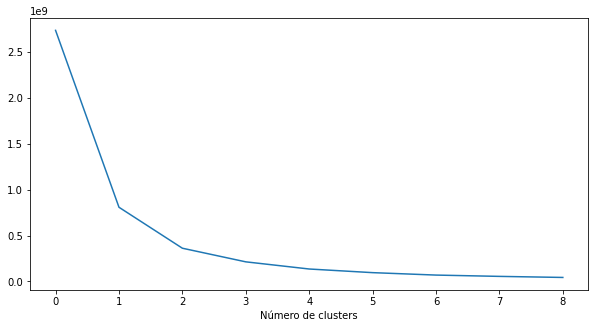

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(soma_quadrados)
plt.xlabel('Número de clusters')
plt.show()